<a href="https://colab.research.google.com/github/nathanschoeck/Computer-Vision/blob/main/Realistic_Image_Extension_(Outpainting)_using_OpenAI_DALL%C2%B7E_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.59.6
    Uninstalling openai-1.59.6:
      Successfully uninstalled openai-1.59.6


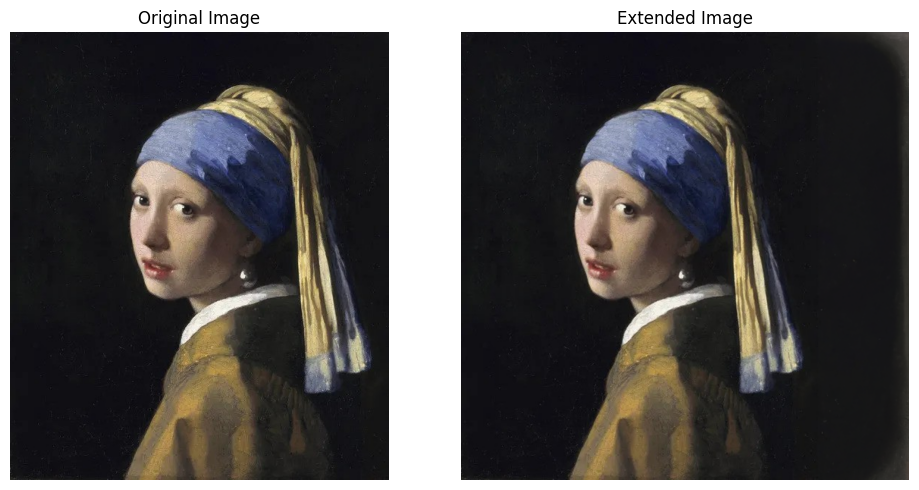

In [6]:
import openai
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

def extend_image_openai(api_key, image_path, extension_pixels, direction="right"):
    """
    Extend an image using OpenAI's DALL·E API for outpainting.

    Parameters:
    - api_key: str, OpenAI API key.
    - image_path: str, Path to the input image.
    - extension_pixels: int, Number of pixels to extend.
    - direction: str, Direction of extension ('top', 'bottom', 'left', 'right').

    Returns:
    - Extended image as a PIL Image object.
    """
    openai.api_key = api_key

    # Load the input image
    image = Image.open(image_path)

    # Resize image to a supported size (e.g., 512x512 or 1024x1024)
    target_size = 1024  # Choose from 256, 512, or 1024
    image = image.resize((target_size, target_size))

    # Convert to RGBA (adds an alpha channel if missing)
    image = image.convert("RGBA")

    # Create a new canvas with transparency for the desired extension
    width, height = image.size
    new_width, new_height = width, height
    if direction == "right":
        new_width += extension_pixels
    elif direction == "left":
        new_width += extension_pixels
    elif direction == "top":
        new_height += extension_pixels
    elif direction == "bottom":
        new_height += extension_pixels

    new_image = Image.new("RGBA", (new_width, new_height), (255, 255, 255, 0))  # Transparent background
    if direction == "right":
        new_image.paste(image, (0, 0))
    elif direction == "left":
        new_image.paste(image, (extension_pixels, 0))
    elif direction == "top":
        new_image.paste(image, (0, extension_pixels))
    elif direction == "bottom":
        new_image.paste(image, (0, 0))

    # Save the new image to a buffer
    buffer = BytesIO()
    new_image.save(buffer, format="PNG")
    buffer.seek(0)

    # Call OpenAI's API for outpainting
    response = openai.Image.create_edit(
        image=buffer,
        mask=None,  # Use the blank space as the mask
        prompt="Extend the image with natural and realistic content that matches the original image.",
        n=1,
        size=f"{target_size}x{target_size}",  # Must be 256x256, 512x512, or 1024x1024
    )

    # Get the outpainted image URL
    image_url = response["data"][0]["url"]

    # Load and return the outpainted image
    response = requests.get(image_url)
    return Image.open(BytesIO(response.content))


# Example usage
if __name__ == "__main__":
    api_key = "sensitive info"
    image_path = "/Girl_with_a_Pearl_Earring.jpg"
    try:
        # Extend the image
        extended_image = extend_image_openai(api_key, image_path, extension_pixels=256, direction="right")

        # Display the original and extended image
        original_image = Image.open(image_path)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_image)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Extended Image")
        plt.imshow(extended_image)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")
